# Segementation with U-Nets

* Maciej Aleksandrowicz 2025, Faculty of Computer Science AGH, 
  * Mainly based on works of D. Kucharski, A. Brodzicki, F. Noworolnik and A. Przeliorz.

U-Net is a convolutional neural network (CNN) architecture that was specifically designed for biomedical image segmentation tasks. Developed in 2015, U-Net has become one of the go-to architectures for various segmentation tasks due to its effectiveness and efficiency.

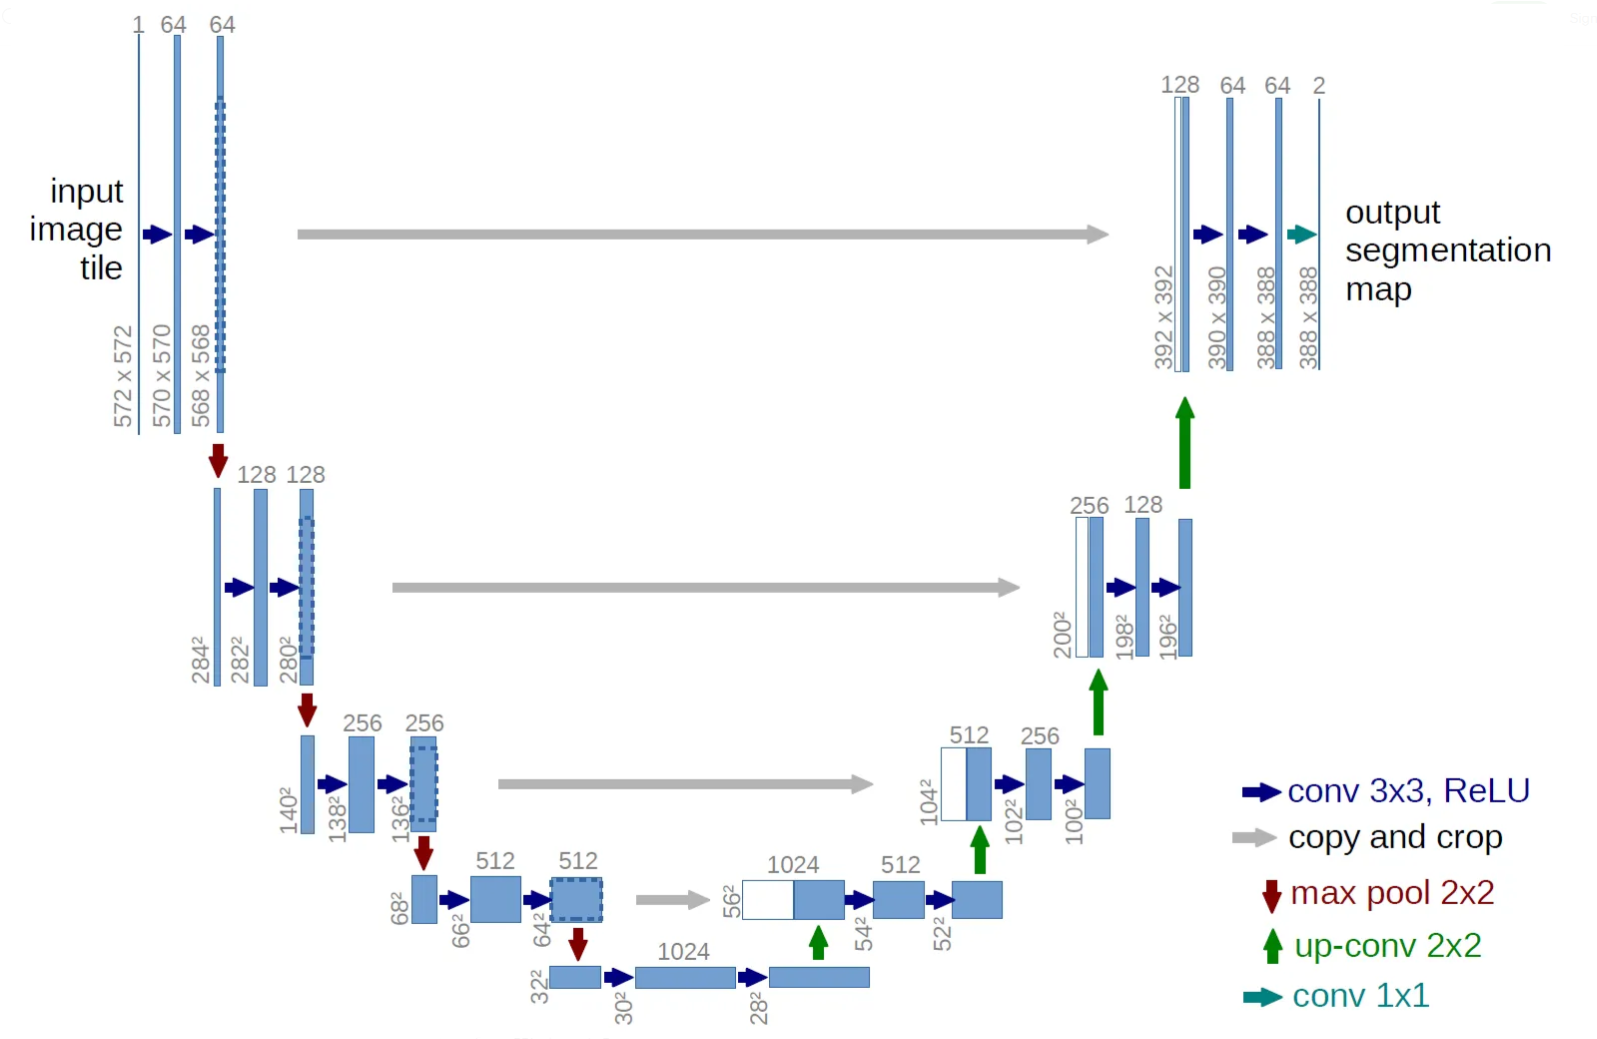
Original paper: [here](https://arxiv.org/pdf/1505.04597v1)

# The U-Net implementation
In this task you will implement your own U-net from scratch using a deep learning framework (Keras or PyTorch).

## Step I
The first step is to download the data by executing the commands below in the terminal or extract it in another way.

```bash
wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
tar -xf images.tar.gz
tar -xf annotations.tar.gz
```

**For a mirror, check the provided AGH Drive link for the laboratires.**

In [ ]:
import tqdm

# TODO - it depends which tools are avaiable in your Collab/Jupyter env
# Use "%" to call commands
%wget #...

UsageError: Line magic function `%wget` not found.


## Step II

The data represents images of animals, along with segmentation masks indicating the object's location in the image with pixel-level accuracy. The images should be loaded as two separate sorted lists: one containing images and the other containing masks. It is important to ensure that the i-th image in the first list corresponds to the i-th mask in the second list. Additionally, due to the quantity and size of the images, they may not fit into memory. Therefore, a good idea would be to store their paths and load them during training.

In [2]:
import os

os.getcwd()

'/net/afscra/people/plgboksa/rozpoznawanie_wzorcow'

In [3]:
# TODO Set the necessary paths
# Choose parameters depending on hardware capabilities
# Check if the data has been downloaded correctly.

# Using pathlib is more convinent than os, do as you wish
from pathlib import Path

input_dir: Path = Path("lab5", "data", "images")
target_dir: Path = Path("lab5", "data", "annotations", "trimaps")
img_size: int = 128
num_classes: int = 3  # Object, background, uncertain area between
batch_size: int = 64
input_img_paths = sorted(list(input_dir.glob("*.jpg")))

raw_target_img_paths = sorted(list(target_dir.glob("*.png")))
target_img_paths = [img for img in raw_target_img_paths if not img.name.startswith(".")]

print(f"Loaded {len(input_img_paths)} input img paths")
print(f"Loaded {len(target_img_paths)} target img paths")


Loaded 7390 input img paths
Loaded 7390 target img paths


In [4]:
for i in range(10):
    print(f"Img path: {input_img_paths[i]}, target: {target_img_paths[i]}")

Img path: lab5/data/images/Abyssinian_1.jpg, target: lab5/data/annotations/trimaps/Abyssinian_1.png
Img path: lab5/data/images/Abyssinian_10.jpg, target: lab5/data/annotations/trimaps/Abyssinian_10.png
Img path: lab5/data/images/Abyssinian_100.jpg, target: lab5/data/annotations/trimaps/Abyssinian_100.png
Img path: lab5/data/images/Abyssinian_101.jpg, target: lab5/data/annotations/trimaps/Abyssinian_101.png
Img path: lab5/data/images/Abyssinian_102.jpg, target: lab5/data/annotations/trimaps/Abyssinian_102.png
Img path: lab5/data/images/Abyssinian_103.jpg, target: lab5/data/annotations/trimaps/Abyssinian_103.png
Img path: lab5/data/images/Abyssinian_104.jpg, target: lab5/data/annotations/trimaps/Abyssinian_104.png
Img path: lab5/data/images/Abyssinian_105.jpg, target: lab5/data/annotations/trimaps/Abyssinian_105.png
Img path: lab5/data/images/Abyssinian_106.jpg, target: lab5/data/annotations/trimaps/Abyssinian_106.png
Img path: lab5/data/images/Abyssinian_107.jpg, target: lab5/data/annot

## Step III
You can plot a sample image and mask using the `imshow` function from the `pyplot` module of the `matplotlib` library: 


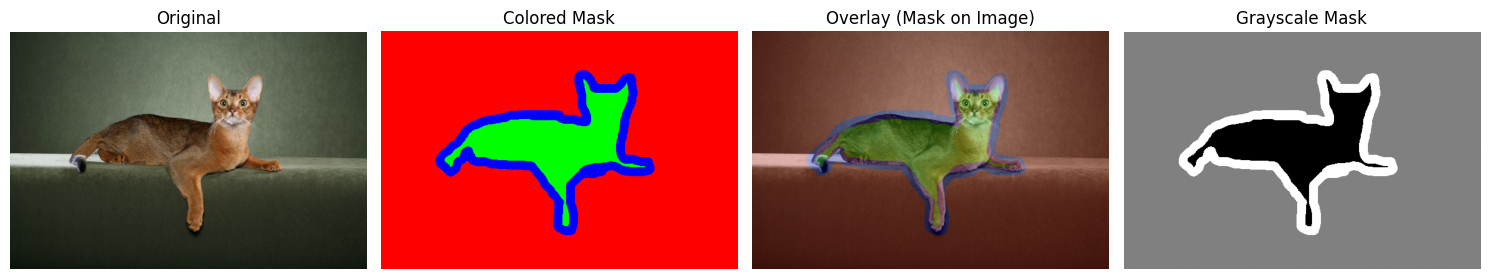

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

example_img_path = input_img_paths[0]
example_mask_path = target_img_paths[0]

img = np.array(Image.open(example_img_path).convert("RGB"))

mask = np.array(Image.open(example_mask_path))

colors = {
    1: np.array([0, 255, 0]),  # pet
    2: np.array([255, 0, 0]),  # border
    3: np.array([0, 0, 255]),  # background
}

color_mask = np.zeros_like(img)

for value, color in colors.items():
    color_mask[mask == value] = color

alpha = 0.2
overlay = (img * (1 - alpha) + color_mask * alpha).astype(np.uint8)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(color_mask)
axes[1].set_title("Colored Mask")
axes[1].axis("off")

axes[2].imshow(overlay)
axes[2].set_title("Overlay (Mask on Image)")
axes[2].axis("off")

if mask.ndim == 3:
    mask_gray = mask[:, :, 0]
else:
    mask_gray = mask

axes[3].imshow(mask_gray, cmap="gray")
axes[3].set_title("Grayscale Mask")
axes[3].axis("off")

plt.tight_layout()
plt.show()

## Step IV
To be able to load images during training, it is necessary to implement an appropriate generator. None of the available generators loads images and their masks. Therefore, it is necessary to write your own generator. 

It depends on which DL library are you using:

**Keras**: Such a class must inherit from the `keras.utils.Sequence` class and implement the methods: `__len__(self)` and `__getitem_(self, idx)__`.

```python
class DataGen(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
 
        # TODO
 
 
    def __len__(self):
 
 
        # TODO
 
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
 
        # TODO
 
        return x, y
```

**PyTorch**: Such a class must inherit from `torch.utils.data.Dataset` and implement the methods: `__len__(self)` and `__getitem__(self, idx)`. This custom dataset class should load and return a pair consisting of an image and its corresponding mask. Then, use `torch.utils.data.DataLoader` to create an iterable over this dataset for batching during training.

```python
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, input_img_paths, target_img_paths):
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        # TODO: return the number of samples
        return len(self.input_img_paths)

    def __getitem__(self, idx):
        # TODO: load image and mask at index idx
        # For example:
        # image = load_image(self.input_img_paths[idx])
        # mask = load_mask(self.target_img_paths[idx])
        # preprocess as needed
        return image, mask
```

Alternatively, you can use existing tools and use two separate generators - one that loads images and another that loads masks, and then combine them into one. 

In [ ]:
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(self, input_img_paths, target_img_paths, img_size=128):
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.img_size = img_size

    def __len__(self):
        return len(self.input_img_paths)

    def __getitem__(self, idx):
        img_path = self.input_img_paths[idx]
        mask_path = self.target_img_paths[idx]

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        img = img.resize((self.img_size, self.img_size))
        mask = mask.resize((self.img_size, self.img_size), resample=Image.NEAREST)

        img = np.array(img, dtype=np.float32) / 255.0
        mask = np.array(mask, dtype=np.int64)

        mask = mask - 1

        img = np.transpose(img, (2, 0, 1))

        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)

        return img, mask

## Step V - Convolutional block
The `__getitem__` method is called for each batch once during one epoch by passing an index. The method should return a tuple with two elements, where the first element is a set of images with the size (batch size, height, width, number of channels), and the second element represents the set of masks for the loaded images. This prepared object of the class is passed to the fit method, which implements the training process. However, it is necessary to implement the architecture of the network beforehand. According to the lecture content, it has a U-shaped structure, and the operations within it include convolutions, max pooling operations, and transposed convolutions. The input to the network is an image, while the output is a mask. It is good to start with the definition of helper functions. A convolutional block:

**Keras**:
```python
from tensorflow.keras import layers
def double_conv_block(x, n_filters):
    x = layers.Conv2D(# TODO)(x)
    x = layers.Conv2D(# TODO)(x)
    return x
# remember to add padding
```

**PyTorch**:
```python
import torch
import torch.nn as nn
def double_conv_block(in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(), # TODO
        nn.ReLU(inplace=True),
        nn.Conv2d() # TODO
        nn.ReLU(inplace=True),
    )
    return block
# remember to configure padding
```

In [ ]:
import torch
import torch.nn as nn


def double_conv_block(in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )
    return block


## Step VI - Sampling block
**Keras**:
```python
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(# todo)(f)
    p = layers.Dropout(# todo)(p)
    return f, p
```

**PyTorch**:
```python
def downsample_block(in_channels, n_filters):
    block = nn.Sequential(
        double_conv_block(in_channels, n_filters),
        nn.MaxPool2d(), # TODO
        nn.Dropout() # TODO
    )
    return block
```

In [ ]:
def downsample_block(in_channels, n_filters, dropout_prob=0.1):
    block = nn.Sequential(
        double_conv_block(in_channels, n_filters),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(dropout_prob),
    )
    return block

## Step VII - Upsampling block
**Keras**:
```python
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(# todo)(x)
    x = double_conv_block(# todo)
    return x
```

**PyTorch**:
```python
class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, conv_features_channels, n_filters, dropout_prob=0.5):
        super(UpSampleBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, n_filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dropout = # TODO
        self.double_conv = # TODO

    def forward(self, x, conv_features):
        x = self.upconv(x)
        # Concatenate along channel dimension
        x = torch.cat([x, conv_features], dim=1)
        x = self.dropout(x)
        x = self.double_conv(x)
        return x
```

In [ ]:
class UpSampleBlock(nn.Module):
    def __init__(
        self, in_channels, conv_features_channels, n_filters, dropout_prob=0.5
    ):
        super(UpSampleBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(
            in_channels, n_filters, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.double_conv = double_conv_block(
            n_filters + conv_features_channels, n_filters
        )

    def forward(self, x, conv_features):
        x = self.upconv(x)
        x = torch.cat([x, conv_features], dim=1)
        x = self.dropout(x)
        x = self.double_conv(x)
        return x

# Step VIII - All togheter
Given all these operations, we can implement the network: 

**Keras**:
```python
import tensorflow as tf
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=(*img_size, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
keras.backend.clear_session()
model = get_model(img_size, num_classes)
```

**PyTorch**:
```python
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(UNet, self).__init__()
        self.down1 = downsample_block(in_channels, 64)
        self.down2 = downsample_block(64, 128)
        self.down3 = downsample_block(128, 256)
        self.down4 = downsample_block(256, 512)
        self.bottleneck = double_conv_block(512, 1024)
        self.up6 = UpSampleBlock(1024, 512, 512)
        self.up7 = UpSampleBlock(512, 256, 256)
        self.up8 = UpSampleBlock(256, 128, 128)
        self.up9 = UpSampleBlock(128, 64, 64)
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        f1 = self.down1[0](x)
        p1 = self.down1[1](f1)
        
        f2 = self.down2[0](p1)
        p2 = self.down2[1](f2)
        
        f3 = self.down3[0](p2)
        p3 = self.down3[1](f3)
        
        f4 = self.down4[0](p3)
        p4 = self.down4[1](f4)
        
        bottleneck = self.bottleneck(p4)
        
        u6 = self.up6(bottleneck, f4)
        u7 = self.up7(u6, f3)
        u8 = self.up8(u7, f2)
        u9 = self.up9(u8, f1)
        
        outputs = self.output_conv(u9)
        outputs = F.softmax(outputs, dim=1)  # softmax for multi-class segmentation
        
        return outputs
```

In [18]:
from torch.functional import F


class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(UNet, self).__init__()
        self.down1 = downsample_block(in_channels, 64)
        self.down2 = downsample_block(64, 128)
        self.down3 = downsample_block(128, 256)
        self.down4 = downsample_block(256, 512)
        self.bottleneck = double_conv_block(512, 1024)
        self.up6 = UpSampleBlock(1024, 512, 512)
        self.up7 = UpSampleBlock(512, 256, 256)
        self.up8 = UpSampleBlock(256, 128, 128)
        self.up9 = UpSampleBlock(128, 64, 64)
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        f1 = self.down1[0](x)
        p1 = self.down1[1](f1)

        f2 = self.down2[0](p1)
        p2 = self.down2[1](f2)

        f3 = self.down3[0](p2)
        p3 = self.down3[1](f3)

        f4 = self.down4[0](p3)
        p4 = self.down4[1](f4)

        bottleneck = self.bottleneck(p4)

        u6 = self.up6(bottleneck, f4)
        u7 = self.up7(u6, f3)
        u8 = self.up8(u7, f2)
        u9 = self.up9(u8, f1)

        outputs = self.output_conv(u9)
        # outputs = F.softmax(outputs, dim=1)

        return outputs

In [24]:
unet = UNet(in_channels=3, num_classes=num_classes)

print(unet)

UNet(
  (down1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1, inplace=False)
  )
  (down2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1, inplace=False)
  )
  (down3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

# Step IX
To verify the network architecture, you can print it to the screen using:

**Kears**: `model.summary()`,

**PyTorch**: `print(model)`.

A good practice is to split the dataset into training, validation, and test subsets. It is necessary to divide the dataset into appropriate subsets. For simplicity, two sets are sufficient – training and validation. 

In [25]:
# TODO: Divide the data into training set and validation set (based on paths)
from torch.utils.data import random_split, DataLoader

dataset = SegmentationDataset(input_img_paths, target_img_paths, img_size=img_size)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Train samples: 6651, Validation samples: 739


as a next step, create generator objects: 

In [26]:
train_gen = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_gen = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Step X - Training and evaluation
* Before starting the training itself, it is necessary to define the loss function (e.x. *Cross-Entropy*) and compile the model.
* Additionally, it is advisable to set up a procedure (in keras - a callback) to save the best model. 
* Finally, the fit function is called with the appropriate arguments.

* During training, the DL libraries logs real-time progress.
* The training time may vary depending on the available hardware.
* If the waiting time is too long, consider reducing the dataset or the number of epochs.
  * However, please note that excessively short training time may result in poor model performance.
* The effectiveness of the model can be assessed using a metric (e.g., accuracy), although it is generally not applied to segmentation problems.

**Keras**:
```python
# TODO - Define loss function
model.compile(# TODO)
model.fit(# TODO)
```

**PyTorch**:
```python
# TODO PLEASE FILL
for epoch in range(num_epochs):
    model.train()
    # TODO ...
    loss.backward()
    optimizer.step()

    # TODO ...
    model.eval()
    with torch.no_grad():
        # ...
torch.save(model.state_dict(), save_path)
```

In [ ]:
from torch import optim
from tqdm import tqdm

num_epochs = 10
device = "cuda"
save_path = "unet_model.pth"

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-3)
unet.to(device)

batch_loss = []
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    unet.train()
    train_loss = 0.0

    for imgs, masks in tqdm(
        train_gen, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"
    ):
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = unet(imgs)  # [B, C, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        batch_loss.append(loss.item())

    train_loss /= len(train_gen.dataset)
    train_losses.append(train_loss)

    unet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(
            val_gen, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"
        ):
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = unet(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_gen.dataset)
    val_losses.append(val_loss)
    print(
        f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
    )

torch.save(unet.state_dict(), save_path)

Epoch 1/10 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch 1/10 | Train Loss: 0.9416 | Val Loss: 0.9260


Epoch 2/10 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.55it/s]


Epoch 2/10 | Train Loss: 0.7478 | Val Loss: 0.6707


Epoch 3/10 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.55it/s]


Epoch 3/10 | Train Loss: 0.6232 | Val Loss: 0.5785


Epoch 4/10 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch 4/10 | Train Loss: 0.5608 | Val Loss: 0.5003


Epoch 5/10 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch 5/10 | Train Loss: 0.4819 | Val Loss: 0.4684


Epoch 6/10 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.64it/s]


Epoch 6/10 | Train Loss: 0.4308 | Val Loss: 0.4163


Epoch 7/10 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch 7/10 | Train Loss: 0.3912 | Val Loss: 0.3918


Epoch 8/10 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch 8/10 | Train Loss: 0.3732 | Val Loss: 0.4025


Epoch 9/10 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.63it/s]


Epoch 9/10 | Train Loss: 0.3478 | Val Loss: 0.3927


Epoch 10/10 - Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.65it/s]

Epoch 10/10 | Train Loss: 0.3337 | Val Loss: 0.3526


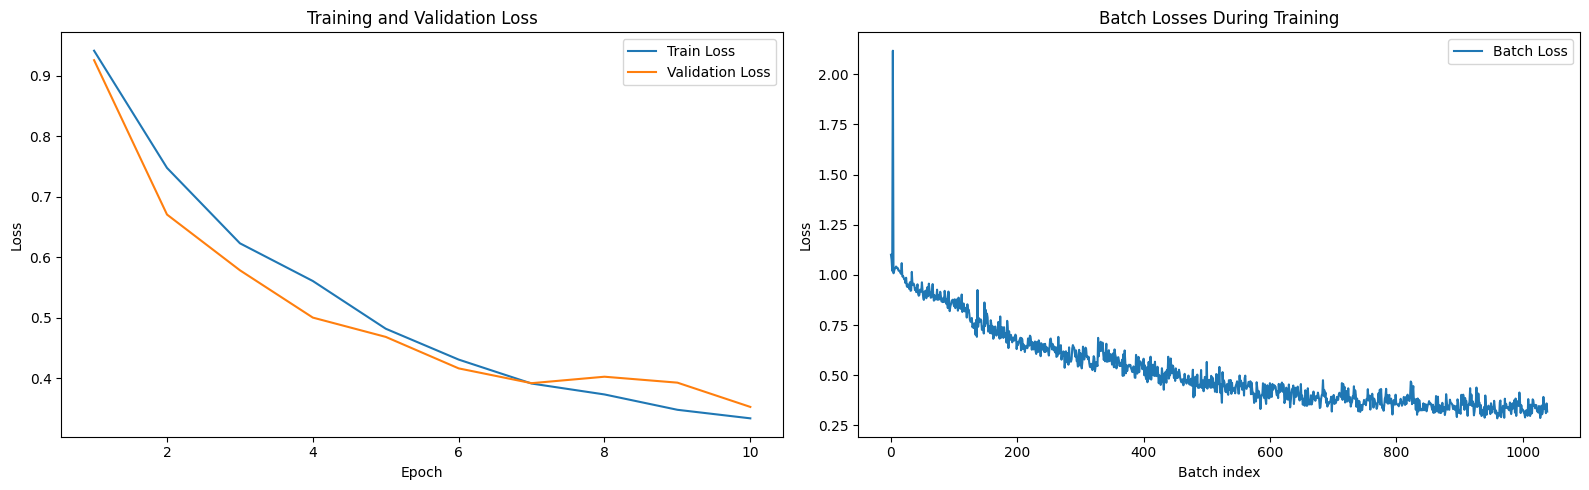

In [ ]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(batch_loss, label="Batch Loss")
plt.xlabel("Batch index")
plt.ylabel("Loss")
plt.title("Batch Losses During Training")
plt.legend()

plt.tight_layout()
plt.show()

# Step XI
* Write and attach one of the metrics for segmentation (e.g., Dice or Jaccard (IoU) ).

In [ ]:
def iou_score(preds, targets, epsilon=1e-6):
    """
    Compute Intersection over Union (IoU) for segmentation
    preds: [B, C, H, W]
    targets: [B, H, W]
    """
    preds = torch.argmax(preds, dim=1)
    iou_per_class = []
    num_classes = preds.max().item() + 1

    for c in range(num_classes):
        pred_c = (preds == c).float()
        target_c = (targets == c).float()

        intersection = (pred_c * target_c).sum()
        union = (pred_c + target_c - pred_c * target_c).sum()

        iou = (intersection + epsilon) / (union + epsilon)
        iou_per_class.append(iou.item())

    return iou_per_class

In [ ]:
unet.eval()
with torch.no_grad():
    iou_scores = []
    for imgs, masks in val_gen:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = unet(imgs)

        iou_scores.append(iou_score(outputs, masks))

iou_mean = np.mean(iou_scores, axis=0)
print("Average IoU per class:", iou_mean)

Average IoU per class: [0.75231255 0.85397985 0.41679278]


### Example on trained net

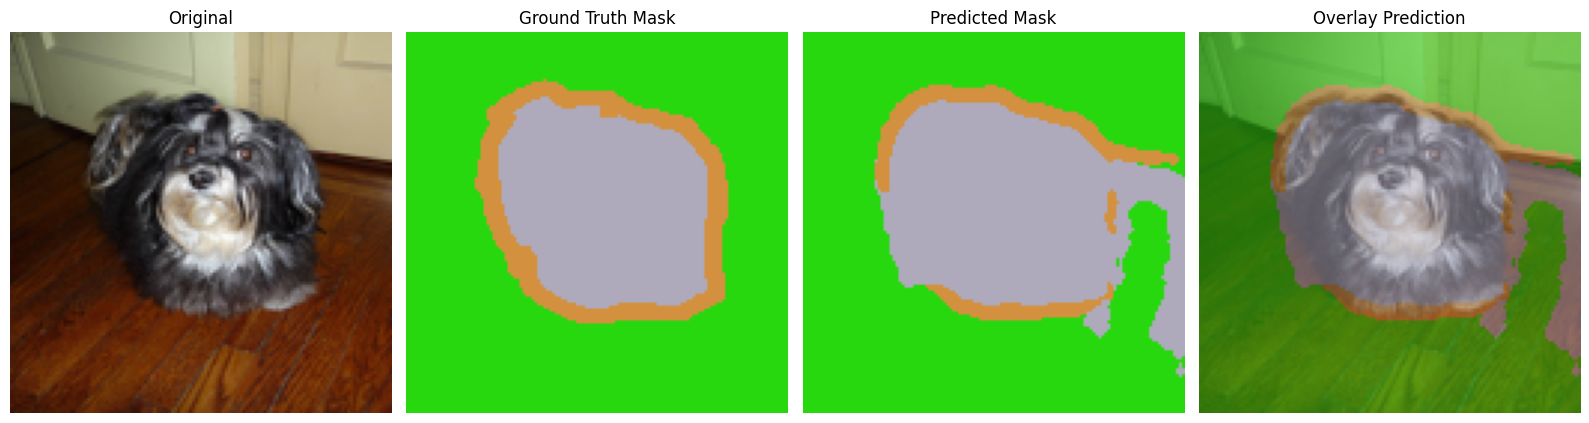

In [ ]:
def get_colormap(num_classes):
    cmap = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)
    return cmap


imgs, masks = next(iter(val_gen))
img = imgs[0]
mask = masks[0]

img_batch = img.unsqueeze(0).to(device)

unet.eval()
with torch.no_grad():
    outputs = unet(img_batch)
    pred_mask = torch.argmax(outputs, dim=1).squeeze(0)

img_np = img.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()
pred_np = pred_mask.cpu().numpy()

cmap = get_colormap(num_classes)
color_mask_gt = cmap[mask_np]
color_mask_pred = cmap[pred_np]

overlay = (0.5 * img_np * 255 + 0.5 * color_mask_pred).astype(np.uint8)

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].imshow((img_np * 255).astype(np.uint8))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(color_mask_gt)
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(color_mask_pred)
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

axes[3].imshow(overlay)
axes[3].set_title("Overlay Prediction")
axes[3].axis("off")

plt.tight_layout()
plt.show()